# Advanced DL and RL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.


## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
        
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
* hit  — взять ещё одну карту;
* stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py


#### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [1]:
import gym
env = gym.make('Blackjack-v0', natural=True)
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
episodes = 1000000
avg_reward = 0

def simplest_policy(state):
    if state[0] >= 19: 
        return 0
    else:
        return 1
    
    
for i in tqdm(range(episodes)):
    state = env.reset()
    is_done = False
    while not is_done:
        action = simplest_policy(state)
        state, reward, is_done, _ = env.step(action)
    avg_reward += (reward - avg_reward) / (i + 1)
    
print(f"Средний выигрыш от самой простой стратегии: {avg_reward}")

  0%|          | 0/1000000 [00:00<?, ?it/s]

Средний выигрыш от самой простой стратегии: -0.1803660000000053


#### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

####  Q-обучение

In [2]:
class Qlearning:
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        env == 'Blackjack-v0'
        self.env = gym.make('Blackjack-v0', natural=True)
        self.na = self.env.action_space.n
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, episodes=100000):
        for n in range(episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, episodes=100000):
        avg_reward = 0
        for i in range(episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            avg_reward += (reward - avg_reward) / (i + 1)
        return avg_reward

In [7]:
q_learn = Qlearning()
q_learn.train(episodes=1000000)
avg_reward = q_learn.inference(episodes=100000)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
print(f"Средний выигрыш Q-learning: {avg_reward}")

Средний выигрыш Q-learning: -0.04901999999999985


#### Monte Carlo control

In [3]:
from collections import defaultdict
import random
def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, episodes=100000):
    avg_reward = 0
    for i in range(episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        avg_reward += (reward - avg_reward) / (i + 1)
    return avg_reward


def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], env.action_space.n)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [11]:
Q_mc, evaluations = monte_carlo(episodes=1000000)
avg_reward = MC_inference(Q_mc, episodes=100000)
print(f"Средний выигрыш Монте-Карло: {avg_reward}")

Средний выигрыш Монте-Карло: -0.025859999999999668


Монте-Карло более убедительный

#### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

#### Grid search

In [13]:
%%time
best_sum_of_rewards = -0.18 # нужно лучше
best_alpha = 0
best_eps = 0
for alpha in tqdm(np.linspace(0.00001, 0.01, 15)):
    for eps in np.linspace(0.05, 0.5, 15):
        QL = Qlearning(alpha=alpha, eps=eps)
        QL.train(10000)
        sum_of_rewards = QL.inference()
        if sum_of_rewards > best_sum_of_rewards:
            best_sum_of_rewards = sum_of_rewards
            best_alpha = alpha
            best_eps = eps

print(f"Лучший выигрыш: {best_sum_of_rewards}, alpha: {best_alpha}, eps: {best_eps}")

  0%|          | 0/15 [00:00<?, ?it/s]

Лучший выигрыш: -0.04266499999999998, alpha: 0.0014371428571428573, eps: 0.30714285714285716
CPU times: user 39min 58s, sys: 4min 1s, total: 44min
Wall time: 37min 33s


Грид сёрч немного улучшил выигрыш

### plot

In [15]:
%%time
QL = Qlearning(alpha=best_alpha, eps=best_eps)
sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(100)):
    QL.train(1000)
    sum_of_rewards = QL.inference()
    sums_of_rewards.append(sum_of_rewards)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 16min 18s, sys: 1min 39s, total: 17min 58s
Wall time: 15min 19s


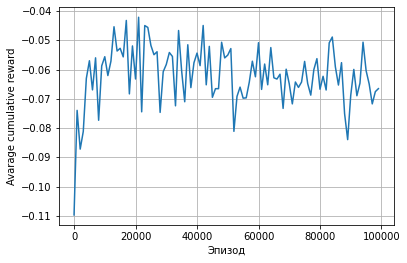

In [17]:
plt.plot(range(0, 100000, 1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.grid()
plt.show()

Обучились довольно быстро

#### Grid search Monte Carlo control and plot

In [26]:
best_sum_of_rewards = -0.18 # нужно лучше
best_gamma = 0

for gamma in tqdm(np.linspace(0., 1, 10)):
    Q_mc, evaluations = monte_carlo(gamma=gamma, episodes=50000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, episodes=100000)
    if sum_of_rewards > best_sum_of_rewards:
        best_sum_of_rewards = sum_of_rewards
        best_gamma = gamma

print(f"Лучший выигрыш: {best_sum_of_rewards}, best_gamma: {best_gamma}")

  0%|          | 0/10 [00:00<?, ?it/s]

Лучший выигрыш: -0.030654999999999755, best_gamma: 0.2222222222222222


маловато эпизодов, грид сёрч показал результаты хуже

In [27]:
sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(50)):
    Q_mc, evaluations = monte_carlo(gamma=best_gamma, episodes=i * 1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, episodes=100000)
    sums_of_rewards.append(sum_of_rewards)

  0%|          | 0/50 [00:00<?, ?it/s]

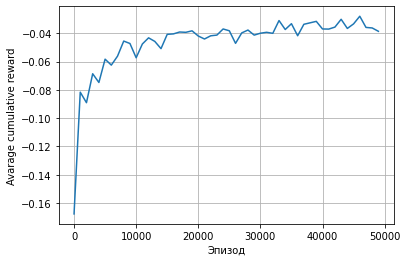

In [28]:
plt.plot(range(0, 50000, 1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.grid()
plt.show()

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:


* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


#### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [4]:
class Doubled_Blackjack_V0_Env:
    def __init__(self):
        self.base_env = gym.make('Blackjack-v0')
        self.action_space = list(range(3))
        
    def reset(self):
        return self.base_env.reset()
    
    def step(self, action):
        if action == 2:            
            state, reward, is_done, _ = self.base_env.step(1)
            
            if is_done:
                return state, 2 * reward, is_done, _            
            else:                
                state, reward, is_done, _ = self.base_env.step(0)
                return state, 2 * reward, is_done, _            
        else:
            return self.base_env.step(action)

In [5]:
class Qlearning_Doubled_Blackjack:
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.env = Doubled_Blackjack_V0_Env()
        self.na = 3
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, episodes=100000):
        for n in range(episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, episodes=100000):
        avg_reward = 0
        for i in range(episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            avg_reward += (reward - avg_reward) / (i + 1)
        return avg_reward

In [35]:
QL_Doubled = Qlearning_Doubled_Blackjack()
QL_Doubled.train(1000000)
avg_reward = QL_Doubled.inference()
print(f"Средний выигрыш Q-learning для удвоенной игры: {avg_reward}")

Средний выигрыш Q-learning для удвоенной игры: -0.10098000000000006


видимо параметры не очень

### Монте-Карло

In [6]:
env = Doubled_Blackjack_V0_Env()

def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, episodes=100000):
    avg_reward = 0
    for i in range(episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        avg_reward += (reward - avg_reward) / (i + 1)
    return avg_reward


def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(3))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], 3)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [41]:
Q_mc, evaluations = monte_carlo(episodes=1000000)
avg_reward = MC_inference(Q_mc, episodes=100000)
print(f"Средний выигрыш MC для удвоенной игры: {avg_reward}")

Средний выигрыш MC для удвоенной игры: -0.05058000000000001


Видимо двойная ставка не так хороша

#### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

#### Grid search q-learning and plot

In [9]:
best_sum_of_rewards = -0.18
best_alpha = 0
best_eps = 0
for alpha in tqdm(np.linspace(0.0001, 0.01, 10)):
    for eps in np.linspace(0.05, 1, 10):
        QL_Doubled = Qlearning_Doubled_Blackjack(alpha=alpha, eps=eps)
        QL_Doubled.train(100000)
        sum_of_rewards = QL_Doubled.inference()
        if sum_of_rewards > best_sum_of_rewards:
            best_sum_of_rewards = sum_of_rewards
            best_alpha = alpha
            best_eps = eps

print(f"Лучший выигрыш: {best_sum_of_rewards}, alpha: {best_alpha}, eps: {best_eps}")

  0%|          | 0/10 [00:00<?, ?it/s]

Лучший выигрыш: -0.03757000000000056, alpha: 0.0001, eps: 1.0


Грид сёрч неплох! (кажется, мы на границе, стоило бы продолжить)

In [10]:
QL_Doubled = Qlearning_Doubled_Blackjack(alpha=best_alpha, eps=best_eps)
sums_of_rewards = []
best_sum_of_rewards = [QL_Doubled.inference()]
for i in tqdm(range(50)):
    QL_Doubled.train(10000)
    sum_of_rewards = QL_Doubled.inference()
    sums_of_rewards.append(sum_of_rewards)

  0%|          | 0/50 [00:00<?, ?it/s]

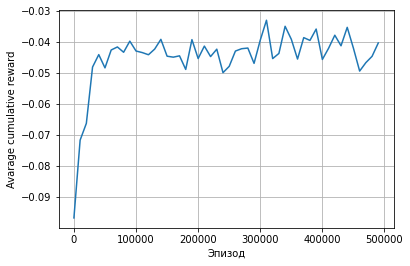

In [11]:
plt.plot(range(0, 500000, 10000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.grid()
plt.show()

Для Монте-Карло обойдемся без поиска по сетке

  0%|          | 0/100 [00:00<?, ?it/s]

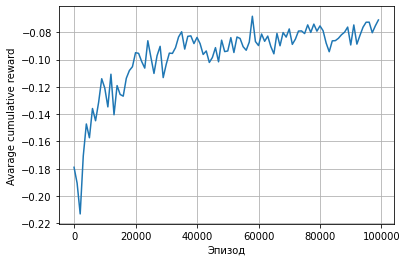

In [14]:
sums_of_rewards = []
best_sum_of_rewards = []
for i in tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=1, episodes=i * 1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, episodes=100000)
    sums_of_rewards.append(sum_of_rewards)
    
plt.plot(range(0, 100000, 1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.grid()
plt.show()

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

#### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде.

In [16]:
from gym.envs.toy_text.blackjack import cmp, is_bust, is_natural, score, sum_hand
from gym import spaces
from gym.envs.toy_text.blackjack import BlackjackEnv


class Doubled_Blackjack_V0_Env(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        self.base_env = gym.make('Blackjack-v0')
        self.action_space = list(range(3))
        super(BlackjackEnv, self).__init__(*args, **kwargs)
        
    def reset(self):
        return self.base_env.reset()
    
    def step(self, action):
        if action == 2:
            state, reward, is_done, _ = self.base_env.step(1)
            if done:
                return state, 2*reward, is_done, _
            else:
                state, reward, is_done, _ = self.base_env.step(0)
                return state, 2*reward, is_done, _
        else:
            return self.base_env.step(action)

class HoffmanBlackjackEnv(Doubled_Blackjack_V0_Env):
    def __init__(self, *args, **kwargs):
        self.base_env = gym.make('Blackjack-v0', natural=True)
        self.na = 3
        self.natural = True
        self.action_space = spaces.Discrete(3)
        self.sum_card = 0
        deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.deck = deck.copy()
        self.card_cost = {
                            1: -1,
                            2: +0.5,
                            3: +1,
                            4: +1,
                            5: +1.5,
                            6: +1,
                            7: +0.5,
                            8: +0,
                            9: -0.5,
                            10: -1,}

        super(HoffmanBlackjackEnv, self).__init__(*args, **kwargs)
        
    def reset(self, deck=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4):
        if len(self.deck) <= 15:
            self.sum_card = 0
            self.deck = deck.copy()
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

    def draw_card(self):
        card = np.random.choice(self.deck)
        self.deck.remove(card)
        self.sum_card += self.card_cost[card]
        return int(card)
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
        
    def _get_obs(self):
        return (*super(Doubled_Blackjack_V0_Env, self)._get_obs(), self.sum_card)
    
    def step(self, action):

        if action: 
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
                
                
            reward = cmp(score(self.player), score(self.dealer))
            
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        return self._get_obs(), reward, done, {}

In [17]:
class Qlearning_hoffman():
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.env = HoffmanBlackjackEnv()
        self.na = 3
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, episodes=100000):
        for n in range(episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, episodes=100000):
        avg_reward = 0
        for i in range(episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            avg_reward += (reward - avg_reward) / (i + 1)
        return avg_reward

In [20]:
QL_Hoffman = Qlearning_hoffman()
QL_Hoffman.train(1000000)
avg_reward = QL_Hoffman.inference()
print(f"Средний выигрыш Q-learning для игры Хоффмана: {avg_reward}")

Средний выигрыш Q-learning для игры Хоффмана: -0.05294499999999936


Посмотрим, что даст грид сёрч

In [22]:
env = HoffmanBlackjackEnv()

def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, episodes=100000):
    avg_reward = 0
    for i in range(episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        avg_reward += (reward - avg_reward) / (i + 1)
    return avg_reward

def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(3))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], 3)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [24]:
Q_mc, evaluations = monte_carlo(episodes=1000000)
avg_reward = MC_inference(Q_mc, episodes=100000)
print(f"Средний выигрыш MC для игры Хоффмана: {avg_reward}")

Средний выигрыш MC для игры Хоффмана: -0.02996500000000002


У метода Монте-Карло результат стабильно хороший, но особенно не улучшается от стратегии к стратегии

#### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

#### Grid search q-learning and plot

In [29]:
best_sum_of_rewards = -0.18
best_alpha = 0
best_eps = 0
for alpha in tqdm(np.linspace(0.0001, 0.01, 5)):
    for eps in np.linspace(0.01, 1, 5):
        QL_Hoffman = Qlearning_hoffman(alpha=alpha, eps=eps)
        QL_Hoffman.train(1000000)
        sum_of_rewards = QL_Hoffman.inference()
        if sum_of_rewards > best_sum_of_rewards:
            best_sum_of_rewards = sum_of_rewards
            best_alpha = alpha
            best_eps = eps

print(f"Лучший выигрыш: {best_sum_of_rewards}, alpha: {best_alpha}, eps: {best_eps}")

  0%|          | 0/5 [00:00<?, ?it/s]

Лучший выигрыш: -0.027480000000000157, alpha: 0.0001, eps: 1.0


выглядит не так уж плохо

In [30]:
QL_Hoffman = Qlearning_hoffman(alpha=best_alpha, eps=best_eps)
sums_of_rewards = []
best_sum_of_rewards = []
for i in tqdm(range(50)):
    QL_Hoffman.train(10000)
    sum_of_rewards = QL_Hoffman.inference()
    sums_of_rewards.append(sum_of_rewards)

  0%|          | 0/50 [00:00<?, ?it/s]

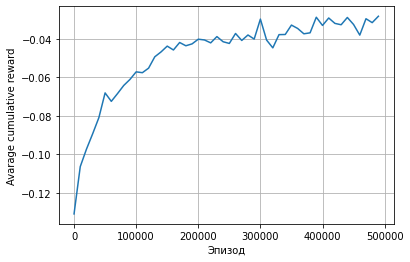

In [31]:
plt.plot(range(0, 500000, 10000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.grid()
plt.show()

Для MC строить не будем

В целом Q-обучение показало себя куда лучше наивного подхода. 

Также в целом новые правила игры показали себя лучше базовых правил